<a href="https://colab.research.google.com/github/TobiasSunderdiek/cartoon-gan/blob/master/CartoonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CartoonGAN

This notebook contains the implementation of the cartoon GAN model. It is implemented with PyTorch. See README [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md) for more details.

## Generate dataset

## Transfer data via google drive
- all image data in this notebook is expected to be zipped to files on local computer as described in README of this project [here](https://github.com/TobiasSunderdiek/cartoon-gan/blob/master/README.md)
- create folder `cartoonGAN` in `My Drive` in google drive
- copy .zip-files `coco.zip`, `safebooru.zip` and `safebooru_smoothed.zip` to google drive `My Drive`/`cartoonGAN`
- mount google drive in this notebook by executing cell below

In [1]:
from google.colab import drive
drive.mount('/content/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/data


### cartoons images

- cartoon images are located in file `content/data/My Drive/cartoonGAN/safebooru.zip` of this notebook
- extract images and place in folder `cartoons` by executing cell below

In [0]:
!mkdir cartoons
!mkdir cartoons/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru.zip -d cartoons/1/ #extract to subfolder due to DataLoader needs subdirectories

##### data-loader

As mentioned in the paper, the used image size is 256x256 pixel.

In [0]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import math

image_size = 256
batch_size = 16

transformer = transforms.Compose([
    transforms.CenterCrop(image_size),
    transforms.ToTensor()
])

cartoon_dataset = ImageFolder('cartoons/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


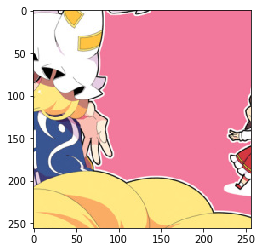

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = iterator.next()
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader_train)

### edge-smoothed cartoons images

- edge-smoothed cartoon images are located in file `content/data/My Drive/cartoonGAN/safebooru_smoothed.zip` of this notebook
- extract images and place in folder `cartoons_smoothed` by executing cell below

In [0]:
!mkdir cartoons_smoothed
!mkdir cartoons_smoothed/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/safebooru_smoothed.zip -d cartoons_smoothed/1/ #extract to subfolder due to DataLoader needs subdirectories

##### data-loader

same configuration as cartoon data loader above

In [0]:
smoothed_cartoon_dataset = ImageFolder('cartoons_smoothed/', transformer)
len_training_set = math.floor(len(smoothed_cartoon_dataset) * 0.9)
len_valid_set = len(smoothed_cartoon_dataset) - len_training_set
training_set, _ = random_split(smoothed_cartoon_dataset, (len_training_set, len_valid_set))
smoothed_cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 0.9725490212440491


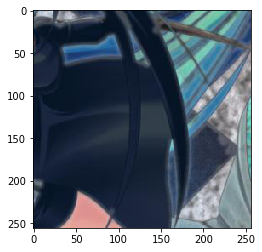

In [7]:
show_sample_image(smoothed_cartoon_image_dataloader_train)

### photos

- photos are located in file `content/data/My Drive/cartoonGAN/coco.zip` of this notebook
- extract images and place in folder `photos` by executing cell below

In [0]:
!mkdir photos
!mkdir photos/1
!unzip -n -q /content/data/My\ Drive/cartoonGAN/coco.zip -d photos/1 #extract to subfolder due to DataLoader needs subdirectories

##### data-loader
same configuration as cartoon data loader above

In [0]:
photo_dataset = ImageFolder('photos/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


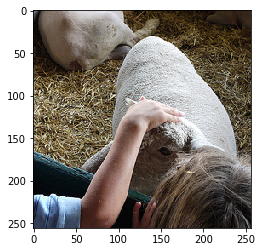

In [10]:
show_sample_image(photo_dataloader_train)

##Define model

The information about the model structure is given in the paper.

For the `zero padding` of the convolutional layers, I use the following formula:

$$Height x Width_{output} = \frac{HeightxWidth_{input} - kernel size + 2 padding}{stride} + 1$$

e.g:

- `conv_1` layer of generator: $HxW$ should stay the same as input size, which is 256x256 and `stride = 1`

$$256 = \frac{256-7+2padding}{1}+1$$

$$padding = 3$$

In case of a fraction as a result, I choose to ceil:

- `conv_2` layer of generator: $\frac{H}{2} x \frac{W}{2}$ is output with `stride=2`

$$128 = \frac{256-3+2padding}{2}+1$$

$$padding= \frac{1}{2} \Rightarrow padding=1$$

###Generator

In the up-convolutional part of the paper, two layers (conv_6 and conv_8 in my implementation) have a stride of 0.5. As pytorchs `conv2D()` does not allow floating point stride, I use a stride of 1 in both cases. Therefore even for the padding calculation I go with a stride of 1.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x #ES

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)
      
      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)
      
      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)
      
      # residual blocks #
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)
      
      # up-convolution #
      self.conv_6 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=33)
      self.conv_7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=65)
      self.conv_9 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)
      
      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))
      
      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))
      
      x = self.res(x)

      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))
      
      x = self.conv_10(x)

      return x

In [12]:
G = Generator()
print(G)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Discriminator

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      
     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)
      
     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)
    
     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)
    
     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    if(torch.isnan(x).any()):
      print("WARN nans 0 -direct input")
    
    x = self.conv_1(x)
    if(torch.isnan(x).any()):
      print("WARN nans 0 -direct after conv_1")
    #x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(x)
    if(torch.isnan(x).any()):
      print("WARN nans 0 -direct after leaky relu 1")
    if(torch.isnan(x).any()):
      print("WARN nans 01")
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    if(torch.isnan(x).any()):
      print("WARN nans 02")
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    if(torch.isnan(x).any()):
      print("WARN nans 03")
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    if(torch.isnan(x).any()):
      print("WARN nans 04")
    x = self.conv_7(x)
    
    return x

In [14]:
D = Discriminator()
print(D)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### move to GPU

In [15]:
import torch

if torch.cuda.is_available():
  G.cuda()
  D.cuda()
  print("Train on GPU. Models moved.")
else:
  print("No cuda available")

Train on GPU. Models moved.


## Loss function
$\mathcal{L}(G, D) = \mathcal{L}_{adv}(G, D) + ω\mathcal{L}_{con}(G, D)$ with ω = 10

This loss is used to train the discriminator and the generator. In the adversarial part, the discriminator tries to classify the generated images as fakes.

During the generator training, the generator tries to minimize the classifications, where the discriminator classifies the generated image as fake. The generator has only affect on the parts of the formula where $G()$ is involved, so the generator tries to minimize this part. Additionally, the loss is not directly calculated from the generator output, but from the discriminator output. Due to the fact that the generator output is the input for the discriminator output in the generator training, the generator is in the chain of the backpropagation, when the loss from the discriminator output is backprogagated all the way back through the discriminator model and generator model to the photo image input data [1], [2].

[1] https://developers.google.com/machine-learning/gan/generator

[2] https://towardsdatascience.com/only-numpy-implementing-gan-general-adversarial-networks-and-adam-optimizer-using-numpy-with-2a7e4e032021

### Adversarial loss

The adversarial loss  $\mathcal{L}_{adv}(G, D)$ which drives the generator to transform photo to comic style of the image. Its value indicates if the output looks like a cartoon image or not. The paper highlights, that a characteristic part of cartoons images are the clear edges, which are a small detail of the image, must be preserved to generate clear edges in the result. In the paper, this is solved by training not only with cartoon images but additionaly by training with the same cartoon images with smoothed edges so that the discriminator can distinguish between clear and smooth edges. For achieving this the authors define the edge-promoting adversarial loss function:

$\mathcal{L}_{adv}(G, D) = \mathbb{E}_{ci∼S_{data}(c)}[log D(c_i)]
+ \mathbb{E}_{ej∼S_{data}(e)}[log(1 − D(e_j))]
+ \mathbb{E}_{pk∼S_{data}(p)}[log(1 − D(G(p_k)))]$

- for the discriminator, this is the formula for the loss function, because output of the Discriminator plays no role within the content loss part of the loss function.

- for the initialization phase of the generator, this part of the formula is not used as described in the paper.

- for the training phase of the generator, only the part of the formula is used within the generator loss function, which the generator can affect: $\mathbb{E}_{pk∼S_{data}(p)}[log(1 − D(G(p_k)))]$

### Content loss
The content loss $ω\mathcal{L}_{con}(G, D)$ which preserves the semantic content during transformation. To calculate this, in the paper the high-level feature maps of the VGG network is used, in particular the layer ($l$) `conv4_4`. The output of the layer $l$ for the original photo is subtracted from the output of the layer $l$ of the generated image. The result is regularized using the $\mathcal{L_1}$ spare regularization ($||...||_1$):

$\mathcal{L}_{con}(G, D)= \mathbb{E}_{pi~S_{data}(p)}[||VGG_l(G(p_i))-VGG_l(p_i)||_1]$

This part of the formula plays a role in the loss function for the generator, not for the discriminator, because only the generator is used within this formula.

More info about $\mathcal{L_1}$ regularization:

https://medium.com/mlreview/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a

https://medium.com/@montjoile/l0-norm-l1-norm-l2-norm-l-infinity-norm-7a7d18a4f40c

In [16]:
from torchvision import models

vgg16 = models.vgg16(pretrained=True)
print(vgg16)

# due VGG16 has 5 pooling-layer, I assume conv4_4 is the 4th pooling layer
# (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
  param.require_grad = False

print(feature_extractor)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.4MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Three loss functions

- discriminator loss
- generator initialization phase loss
- generator loss

In order to return a single scalar-value as result of the loss function, I choose to calculate the mean as last step of the loss calculation.

In [0]:
from torchvision import models

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input):

    result = torch.log(torch.abs(discriminator_output_of_cartoon_input)) +\
             torch.log(torch.abs(1 - discriminator_output_of_cartoon_smoothed_input)) +\
             torch.log(torch.abs(1 - discriminator_output_of_generated_image_input))

    return torch.mean(result **2)

In [0]:
class GeneratorInitPhaseLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorInitPhaseLoss, self).__init__()
      vgg16 = models.vgg16(pretrained=True)
      if torch.cuda.is_available():
        vgg16.cuda()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, generator_input, generator_output):
    return self._content_loss(generator_input, generator_output)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [0]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 10
      vgg16 = models.vgg16(pretrained=True)
      if torch.cuda.is_available():
        vgg16.cuda()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output):
    return self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input) +\
        self.w * self._content_loss(generator_input, generator_output)

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    return torch.mean(torch.log(torch.abs(discriminator_output_of_generated_image_input)) **2)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [0]:
discriminatorLoss = DiscriminatorLoss()
generatorInitPhaseLoss = GeneratorInitPhaseLoss()
generatorLoss = GeneratorLoss()

## Optimizer
In the paper, the used optimizer is not mentioned, I decide to choose adam.

For hyperparameter-tuning, I decided to go with the same parameters mentioned in the DCGAN-paper[1].

[1] https://arxiv.org/pdf/1511.06434.pdf

In [0]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Training
To make training resumeable, I save some checkpoints to google drive and load them, if existing, before run the training.

In [22]:
!mkdir /content/data/My\ Drive/cartoonGAN/checkpoints/

mkdir: cannot create directory ‘/content/data/My Drive/cartoonGAN/checkpoints/’: File exists


In [0]:
import time

def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for batch_index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):

      batch_size = photo_images.size(0)
      if torch.cuda.is_available():
        photo_images = photo_images.cuda()
        smoothed_cartoon_images = smoothed_cartoon_images.cuda()
        cartoon_images = cartoon_images.cuda()

      # train the discriminator
      d_optimizer.zero_grad()

      discriminator_output_of_cartoon_input = D(cartoon_images)
      discriminator_output_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
      discriminator_output_of_generated_image_input = D(G(photo_images))

      d_loss = discriminatorLoss(discriminator_output_of_cartoon_input,
                            discriminator_output_of_cartoon_smoothed_input,
                            discriminator_output_of_generated_image_input)

      d_loss.backward()
      d_optimizer.step()

      # train the generator
      g_optimizer.zero_grad()

      generator_output = G(photo_images)
      discriminator_output_of_generated_image_input = D(generator_output)

      if epoch < init_epochs:
        # init
        g_loss = generatorInitPhaseLoss(photo_images, generator_output)
      else:
        # train
        g_loss = generatorLoss(discriminator_output_of_generated_image_input,
                             photo_images,
                             generator_output)

      g_loss.backward()
      g_optimizer.step()

      if(math.isnan(d_loss.item()) or math.isnan(g_loss.item())):
        print("ERROR losses contain nans")
        return #to leave inner loop and do break

      if batch_index % print_every == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))
    
    # validate
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        if torch.cuda.is_available():
          photo_images = photo_images.cuda()

        generator_output = G(photo_images)
        discriminator_output_of_generated_image_input = D(generator_output)
        g_valid_loss = generatorLoss(discriminator_output_of_generated_image_input, photo_images, generator_output)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()

    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()

    # save checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                   'best_valid_loss': best_valid_loss,
                   'losses': losses,
                   'validation_losses': validation_losses,
                   'last_epoch': epoch,
                   'd_state_dict': D.state_dict(),
                   'g_state_dict': G.state_dict(),
                   'd_optimizer_state_dict': d_optimizer.state_dict(),
                   'g_optimizer_state_dict': g_optimizer.state_dict()
                 }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')

  return losses, validation_losses

In [46]:
from os import listdir

checkpoint_dir = '/content/data/My Drive/cartoonGAN/checkpoints'
checkpoints = listdir(checkpoint_dir)
num_epochs = 200 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
  last_checkpoint = sorted(checkpoints)[-1]
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint)
  best_valid_loss = checkpoint['best_valid_loss']
  epochs_already_done = checkpoint['last_epoch']
  losses = checkpoint['losses']
  validation_losses = checkpoint['validation_losses']
  
  D.load_state_dict(checkpoint['d_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


Load checkpoint checkpoint_epoch_086.pth with g_valid_loss 9531305.0, best_valid_loss 8018956.5, 85 epochs and total no of losses 291


In [47]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 86/210 | d_loss 8.0364 | g_loss 10523662.0000 | time  2s | total no. of losses 292
Epoch 86/210 | d_loss 7.6790 | g_loss 10838222.0000 | time 210s | total no. of losses 293
Epoch 86/210 | d_loss 6.6517 | g_loss 11108088.0000 | time 210s | total no. of losses 294
Epoch 86/210 | validation loss 11736334.0000 | time 48s | total no. of losses 98
Save checkpoint for validation loss of 10564719.0
Epoch 87/210 | d_loss 6.6969 | g_loss 10842022.0000 | time  9s | total no. of losses 295
Epoch 87/210 | d_loss 5.8008 | g_loss 12154557.0000 | time 211s | total no. of losses 296
Epoch 87/210 | d_loss 4.8515 | g_loss 10500623.0000 | time 210s | total no. of losses 297
Epoch 87/210 | validation loss 9624987.0000 | time 48s | total no. of losses 99
Save checkpoint for validation loss of 10222646.0
Epoch 88/210 | d_loss 6.1394 | g_loss 10835766.0000 | time  9s | total no. of losses 298
WARN nans 0 -direct after conv_1
WARN nans 0 -direct after leaky relu 1
WARN nans 01
WARN nans 02
WARN nans 03
W

TypeError: ignored

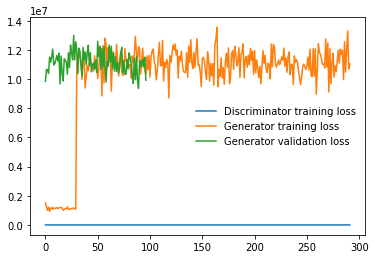

In [29]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

import matplotlib.pyplot as plt

d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)

##Inference

In [33]:
checkpoint = torch.load(checkpoint_dir + '/best_checkpoint.pth')
G_inference = Generator()
G_inference.load_state_dict(checkpoint['g_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


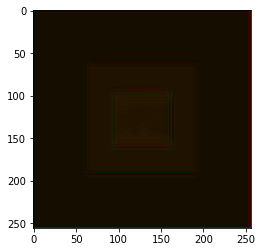

In [58]:
test_images = iter(photo_dataloader_valid).next()[0]
result_images = G_inference(test_images)
plt.imshow(np.transpose(result_images[0].detach().numpy(), (1, 2, 0)))

## Notes/next steps
- alternative lib for image processing: https://github.com/albu/albumentations
- figure out which variant of VGG to use (VGG-16?), and if the pre-training in the referenced paper is the same as the pre-trained pytorch version
- do I use the correct `log` in adversarial loss?
- do I use correct normalization-method in content loss
- hyperparameter tuning with tune
- in which order is the discriminator trained regarding photos, cartoons with smoothed edges and then genereated images?
- evaluate result with existing model http://cg.cs.tsinghua.edu.cn/people/~Yongjin/CartoonGAN-Models.rar ?
- did I split the loss function correctly for the D and G model, and content loss only for G?
- plot results directly from vars via method
- is choosing mean as last step within loss functions correct?
- is choosing abs() to transform generator/discriminator output to positive value for loss function correct? (due to negative input for log() produces NaN)
- d_loss, (g_loss?) produces negtive values by only using mean(), is it correct to square the result before mean?
- in the paper 6.000 photo images and 2.000 - 4.000 cartoon images are used for training, how is this done with unbalanced datasets?
- is batch_size of 16 correct? Tried 32 before, but got CUDA OOM
- for image downloader: catch exception if image is truncated/check if zipping adds additional folder within .zip in create_smoothed_images.py
- validation loss within init phase is not calculated with init-loss function